<a href="https://colab.research.google.com/github/silverstar0727/study-/blob/master/Basic_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 분류기(Classifier)
우선 데이터를 불러오는 방법에 대해 알아보자
* 이미지는 pillow나 OpenCV의 패키지가 유용함
* 오디오는 scipy나 libROSA가 유용함
* 텍스트는 python, cython, NLTK, SpaCy도 유용함

영상 분야에서는 torchvision이라는 패키지가 잘 되어있다.

이번 실습에서는 CIFAR10 데이터셋을 사용하는데, 3x32x32 크기의 이미지 즉, 32x32픽셀 크기의 이미지가 3개의 채널의 색상으로 이루어진 데이터를 사용할 것이다. 이들은 다양한 종류의 사진인데 종류별로 분류하는 것을 목적으로 한다

* torchvision을 이용하여 데이터를 불러오고 normalization을 함
* 합성곱 신경망(CNN)정의
* 손실함수 결정
* 학습용 데이터를 사용한 신경망 학습
* 테스트 데이터를 사용한 신경망 검사

위의 순서로 진행

## 데이터 셋 load 및 normalization

torchvision의 데이터 셋은 [0, 1] 범위의  PILImage인데 이를 [-1, 1]의 정규화 된 tensor로 변환함

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 간단히 이미지 보기

 bird   cat   cat  deer


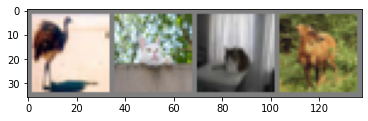

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# CNN 모델 구성

In [ ]:
# CNN정의하기
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()

# loss function & optimizer 정의하기

In [ ]:
# loss function & Optimizer 정의하기
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)


# Training

In [ ]:
# 신경망 학습하기
for epoch in range(2): # 데이터 셋을 반복할 횟수
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    # [inputs, labels]의 목록을 data로부터 입력을 받고
    inputs, labels = data
    # gradient 매개변수를 0으로 만들기
    optimizer.zero_grad()

    # forward propagation + backward propagation + optimization
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # 통계를 출력
    running_loss += loss.item()
    if i % 2000 == 1999: # 2000개의 minibatch마다 출력하기
      print('[%d, %5d loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0


print('finish')

[1,  2000 loss: 2.165
[1,  4000 loss: 1.800
[1,  6000 loss: 1.631
[1,  8000 loss: 1.551
[1, 10000 loss: 1.518
[1, 12000 loss: 1.473
[2,  2000 loss: 1.393
[2,  4000 loss: 1.352
[2,  6000 loss: 1.346
[2,  8000 loss: 1.335
[2, 10000 loss: 1.304
[2, 12000 loss: 1.276
finish


# 모델저장

In [ ]:
path = './cifer_net.pth'
torch.save(net.state_dict(), path)

# Test

GroundTruth:    cat  ship  ship plane


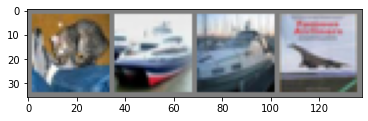

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 저장한 모델 불러오기

In [ ]:
net = Net()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
_, predicted = torch.max(outputs, 1) # 가장 높은 값을 같는 인덱스를 뽑아보기

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird plane  bird  deer


In [ ]:
# 전체데이터 셋에 적용

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [ ]:
# 종류별 비교
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 68 %
Accuracy of  bird : 40 %
Accuracy of   cat : 41 %
Accuracy of  deer : 42 %
Accuracy of   dog : 40 %
Accuracy of  frog : 72 %
Accuracy of horse : 60 %
Accuracy of  ship : 64 %
Accuracy of truck : 71 %


## GPU에서 학습하기

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)